# Feature Impute and Train

## Summary:

Below are the predictions for 3yr cumulative oil recovery.

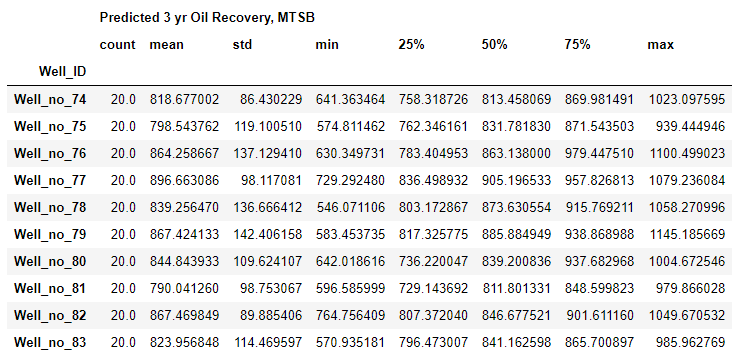




We model oil recovery using an artificial neural network that considers the petrophysical properties of the wellbore, measured at each depth. Using our ANN, we predict the oil recovery at each depth interval, and aggregate these predictions to produce the mean oil recovery per well. The following outline the advantages of this approach:  

Predictions scale with well depth and new information. That is, there is no need to retrain the model if additional well log data comes is added, because the model outputs incremental recovery predictions for every new data point.

The model is tolerant to incomplete data. (so are others?)  

Predictions have less uncertainty, because there is no upscaling. Users can predict depth-dependent recovery estimates, and identify depth intervals of high production.

We choose the following depth-dependent numerical attributes as predictor features: Porosity, fraction	Permeability, mD	Acoustic Impedance, kg*s/m^2	Density, g/cm3	Compressible velocity, m/s	Youngs modulus, GPa	Shear velocity, m/s	Shear modulus, GPa.  

Label: Petrophysics-dependent cumulative oil recovery, MTSB, predicted for each depth and for each well.  

### Training Steps

For predictor features  
Drop non predictor features from the input,  
Standardize all predictor features,    
Perform KNearestNeighbors with 8 neighbors,  
Normalize to 0-1 (minmax).   
 
For labels,  
Perform log transformation

ANN hyperparameters:  2 layers, 10 nodes each, 100 epochs.  










Rock facies has 8.9\% missing values, and is categorical which takes an extra step to impute.

In [1]:
# Import all the good stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin


import tensorflow as tf

import os
import pandas as pd
import tensorflow as tf
import subprocess
import pickle
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer


In [2]:
# Read producer
prod = pd.read_csv("https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/wellbore_data_producer_wells.csv?token=AN5MCLBHM2IYJT6OO42JN43AQDE4U")
# Read cumulative oil
cumoil = pd.read_csv('https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/data_exp/production_history.csv?token=AN5MCLGECACCOYCJDAQCPYTAQDFCE')

In [3]:
# Join on Well_ID (Left outer join)
df = pd.merge(prod, cumoil, on='Well_ID',how='left')
df.head()


,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,450.98,684.2,847.33,494.89,1236.4,2108.7
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,450.98,684.2,847.33,494.89,1236.4,2108.7
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN,450.98,684.2,847.33,494.89,1236.4,2108.7
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,450.98,684.2,847.33,494.89,1236.4,2108.7
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834,450.98,684.2,847.33,494.89,1236.4,2108.7


In [4]:
# Split test-train, set 10% aside as test set
df_train, df_test=train_test_split(df, test_size=0.1, random_state=42)

In [60]:
# Select label column.
y_train = df_train['Cumulative oil production (3 yr), MSTB'].copy()
y_test = df_test['Cumulative oil production (3 yr), MSTB'].copy()
y_full = df['Cumulative oil production (3 yr), MSTB'].copy()

In [62]:
# Reshape label column, because pipelines require 2D data.
y_train = np.array(y_train).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))
y_full = np.array(y_full).reshape((-1,1))

In [7]:
# Create ANN model for oil recov
def model_construct(n_layers, n_nodes, n_inputs):
    '''
    n_layers
    n_nodes
    n_inputs: Dims of inputs, X_train_prepared.shape[1]
    '''
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=[n_inputs]))
    for _ in range(n_layers-1):
        model.add(tf.keras.layers.Dense(n_nodes, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(tf.keras.layers.Dense(1))

    # Remove lr if scheduler in use?
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                  metrics=['mse', 'mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [8]:
# Store version info as file in directory
def get_git_revision_hash():
    return subprocess.check_output(['git', 'rev-parse', 'HEAD'])

In [9]:
# Function to train ANN model
def train_model(model,
                X,
                y,
                X_test,
                y_test,
                batch_size,
                n_layers,
                n_nodes,
                epochs,
                initial_epoch,
                log_save_dir,
                name_prefix):
    # Create Directory for Logs
    model_name = name_prefix+'_'+str(batch_size)+'_'+str(n_layers)+'_'+str(n_nodes)+'_'+str(epochs)+'_'
    logdir = log_save_dir + ".\\logs\\scalars\\" + model_name + str(
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    logdir = logdir
    if not os.path.exists(logdir):
        os.makedirs(logdir)
        print('New logdir created.')
        
    # Logs
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=logdir,
        histogram_freq=0,  # How often to log histogram visualizations
        write_graph=True,
        update_freq='epoch',
        profile_batch=0,  # set to 0. Else bug Tensorboard not show train loss.
        embeddings_freq=0,  # How often to log embedding visualizations
    )
    
    # Early stop
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', min_delta=0.001, patience=3)

    # Save Checkpoint
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=logdir,  # +'.\\{epoch:.02d}-{mse:.2f}',
        verbose=1,
        save_weights_only=False,
        monitor='mse',  # Not sure
        mode='auto',
        save_best_only=True)

    with open(logdir + '.\\version_info.txt', 'a', newline='') as file:
        file.write('model_name'+' '+str(get_git_revision_hash()) + '\n')

    # Train. History stores loss metrics per epoch
    history = model.fit(X, y, initial_epoch=initial_epoch, epochs=epochs,
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                        validation_data=(X_test, y_test),
                        shuffle=True,
                        batch_size=batch_size, verbose=2)

    # Save entire model with training config
    model.save(logdir + '.\\' + model_name + '{}'.format(str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))))
    
    return model

    endTime = datetime.datetime.now()
    print('Ended at ' + str(endTime))
    print('end')

In [10]:
# Define Transformers
# Select columns and standardize them. Drop all remaining.
std_scaler_X = StandardScaler()
select_and_std=make_column_transformer((std_scaler_X,[4,5,6,8,9,10,11,12]))

In [11]:
# Transformer for features, min-max normalize
x_min_max_scaler = MinMaxScaler()

In [12]:
# Custom log transformer
log_transformer = FunctionTransformer(np.log,np.exp, validate=True)

In [13]:
# Define transformation pipeline for label

label_pipe = Pipeline([
    ('select column and log transform', log_transformer)
])

In [14]:
# Define transformation pipeline for features
feature_pipe = Pipeline([
    ('Select_cols_and_std',select_and_std),
    ('Iterative_impute_KNN',IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=8))),
    ('PCA',PCA(n_components=4)),
    ('minmax',x_min_max_scaler)
])

In [15]:
# Fit transform predictor features
X_train_prepared=feature_pipe.fit_transform(df_train)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [31]:
# Transform test predictor features
X_test_prepared=feature_pipe.transform(df_test)

In [32]:
# Fit transform labels
y_train_prepared = label_pipe.fit_transform(y_train)

In [33]:
# Transform test labels
y_test_prepared = label_pipe.transform(y_test)

In [34]:
# Test Inverse transform the labels
temp=pd.DataFrame(label_pipe.inverse_transform(y_train_prepared))
temp.describe()

,0
count,1314.000000
mean,940.556910
std,428.179955
min,307.120000
25%,643.140000
50%,819.490000
75%,1185.400000
max,2514.500000


In [35]:
# Verify inverse transform for label is good. That is, the summary statistics are identical.
pd.DataFrame(y_train).describe()

,0
count,1314.000000
mean,940.556910
std,428.179955
min,307.120000
25%,643.140000
50%,819.490000
75%,1185.400000
max,2514.500000


### Train
Train model using the train data subset (90% of entire data) to find good hyperparameters. We found 2 layers, 10 nodes to be good. Model does not overfit, as the validation error does not exceed the train error.

In [44]:
# Compile ANN architecture (nodes, layers)
# Choose leaky ReLU arbitratily. Should have fast convergence.
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=2
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_train_prepared.shape[1])

In [45]:
log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='oilrecov_log_nlayers{}_nodes{}_epochs{}_split_v4'.format(n_layers,n_nodes,50)
model = train_model(oilrecov3_model,
                X_train_prepared,
                y_train_prepared,
                X_test_prepared,
                y_test_prepared,                    
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=100,
                initial_epoch=0,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)

New logdir created.
Train on 1314 samples, validate on 146 samples
Epoch 1/100

Epoch 00001: mse improved from inf to 42.49601, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 2s - loss: 42.4960 - mse: 42.4960 - mae: 6.5023 - mean_absolute_percentage_error: 96.2913 - val_loss: 39.6666 - val_mse: 39.6666 - val_mae: 6.2834 - val_mean_absolute_percentage_error: 92.8619
Epoch 2/100

Epoch 00002: mse improved from 42.49601 to 36.33027, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov

1314/1314 - 1s - loss: 0.8647 - mse: 0.8647 - mae: 0.7382 - mean_absolute_percentage_error: 10.8845 - val_loss: 0.8077 - val_mse: 0.8077 - val_mae: 0.7283 - val_mean_absolute_percentage_error: 10.6664
Epoch 15/100

Epoch 00015: mse improved from 0.86468 to 0.84893, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.8489 - mse: 0.8489 - mae: 0.7307 - mean_absolute_percentage_error: 10.7845 - val_loss: 0.7898 - val_mse: 0.7898 - val_mae: 0.7205 - val_mean_absolute_percentage_error: 10.5598
Epoch 16/100

Epoch 00016: mse improved from 0.84893 to 0.83374, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.6699 - mse: 0.6699 - mae: 0.6489 - mean_absolute_percentage_error: 9.5848 - val_loss: 0.6216 - val_mse: 0.6216 - val_mae: 0.6336 - val_mean_absolute_percentage_error: 9.2950
Epoch 29/100

Epoch 00029: mse improved from 0.66989 to 0.65595, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.6559 - mse: 0.6559 - mae: 0.6423 - mean_absolute_percentage_error: 9.5012 - val_loss: 0.6060 - val_mse: 0.6060 - val_mae: 0.6264 - val_mean_absolute_percentage_error: 9.1983
Epoch 30/100

Epo

Epoch 42/100

Epoch 00042: mse improved from 0.49141 to 0.47672, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.4767 - mse: 0.4767 - mae: 0.5455 - mean_absolute_percentage_error: 8.0880 - val_loss: 0.4455 - val_mse: 0.4455 - val_mae: 0.5373 - val_mean_absolute_percentage_error: 7.9074
Epoch 43/100

Epoch 00043: mse improved from 0.47672 to 0.46209, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\as

1314/1314 - 1s - loss: 0.3061 - mse: 0.3061 - mae: 0.4362 - mean_absolute_percentage_error: 6.4809 - val_loss: 0.2866 - val_mse: 0.2866 - val_mae: 0.4343 - val_mean_absolute_percentage_error: 6.4471
Epoch 56/100

Epoch 00056: mse improved from 0.30605 to 0.29491, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.2949 - mse: 0.2949 - mae: 0.4287 - mean_absolute_percentage_error: 6.3916 - val_loss: 0.2844 - val_mse: 0.2844 - val_mae: 0.4325 - val_mean_absolute_percentage_error: 6.3496
Epoch 57/100

Epoch 00057: mse improved from 0.29491 to 0.28257, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_1

INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.2030 - mse: 0.2030 - mae: 0.3586 - mean_absolute_percentage_error: 5.3482 - val_loss: 0.1866 - val_mse: 0.1866 - val_mae: 0.3453 - val_mean_absolute_percentage_error: 5.1129
Epoch 70/100

Epoch 00070: mse improved from 0.20302 to 0.20013, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.2001 - mse: 0.2001 - mae: 0.3563 - mean_absolute_percentage_error: 5.3161 - val_loss: 0.1825 - val_mse: 0.1825 - val_mae: 0.3410 - val_mean_absolute_percentage_error: 5.0531
Epoch 71/100

Epo

Epoch 85/100

Epoch 00085: mse improved from 0.17307 to 0.17275, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\assets
1314/1314 - 1s - loss: 0.1727 - mse: 0.1727 - mae: 0.3327 - mean_absolute_percentage_error: 4.9570 - val_loss: 0.1550 - val_mse: 0.1550 - val_mae: 0.3140 - val_mean_absolute_percentage_error: 4.6488
Epoch 86/100

Epoch 00086: mse improved from 0.17275 to 0.17213, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs50_split_v4_32_2_10_100_20210418-081259\as

### Train on full data
Repeat training on full data, with hyperparameters found in previous step. Validation mean absolute percent error: 4.5%.

In [59]:
# Fit transform predictor features
X_full_prepared=feature_pipe.fit_transform(df)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [63]:
# Transform test labels
y_full_prepared = label_pipe.transform(y_full)

In [64]:
# Compile ANN architecture (nodes, layers)
# Choose leaky ReLU arbitratily. Should have fast convergence.
# Search hyperparameters for best model. n_layers, n_nodes, training epochs.
n_layers=2
n_nodes=10
oilrecov3_model = model_construct(n_layers, n_nodes, X_train_prepared.shape[1])

In [65]:
log_save_dir=r'C:\Users\win7\PycharmProjects\PGE_hack_local\logs'
name_prefix='oilrecov_log_nlayers{}_nodes{}_epochs{}_full'.format(n_layers,n_nodes,100)
model = train_model(oilrecov3_model,
                X_train_prepared,
                y_train_prepared,
                X_test_prepared,
                y_test_prepared,                    
                batch_size=32,
                n_layers=n_layers,
                n_nodes=n_nodes,
                epochs=100,
                initial_epoch=0,
                log_save_dir=log_save_dir,
                name_prefix=name_prefix)

New logdir created.
Train on 1314 samples, validate on 146 samples
Epoch 1/100

Epoch 00001: mse improved from inf to 41.32863, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 2s - loss: 41.3286 - mse: 41.3286 - mae: 6.4116 - mean_absolute_percentage_error: 94.9441 - val_loss: 38.1527 - val_mse: 38.1527 - val_mae: 6.1607 - val_mean_absolute_percentage_error: 91.0399
Epoch 2/100

Epoch 00002: mse improved from 41.32863 to 34.40870, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlay

1314/1314 - 1s - loss: 0.8234 - mse: 0.8234 - mae: 0.7092 - mean_absolute_percentage_error: 10.4400 - val_loss: 0.6941 - val_mse: 0.6941 - val_mae: 0.6739 - val_mean_absolute_percentage_error: 9.9004
Epoch 15/100

Epoch 00015: mse improved from 0.82338 to 0.80194, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 1s - loss: 0.8019 - mse: 0.8019 - mae: 0.7004 - mean_absolute_percentage_error: 10.3131 - val_loss: 0.6759 - val_mse: 0.6759 - val_mae: 0.6648 - val_mean_absolute_percentage_error: 9.7713
Epoch 16/100

Epoch 00016: mse improved from 0.80194 to 0.78091, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_2

1314/1314 - 1s - loss: 0.5528 - mse: 0.5528 - mae: 0.5845 - mean_absolute_percentage_error: 8.6273 - val_loss: 0.4829 - val_mse: 0.4829 - val_mae: 0.5613 - val_mean_absolute_percentage_error: 8.2673
Epoch 29/100

Epoch 00029: mse improved from 0.55284 to 0.53924, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 1s - loss: 0.5392 - mse: 0.5392 - mae: 0.5772 - mean_absolute_percentage_error: 8.5338 - val_loss: 0.4768 - val_mse: 0.4768 - val_mae: 0.5587 - val_mean_absolute_percentage_error: 8.2084
Epoch 30/100

Epoch 00030: mse improved from 0.53924 to 0.51916, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_202

1314/1314 - 1s - loss: 0.3485 - mse: 0.3485 - mae: 0.4647 - mean_absolute_percentage_error: 6.8902 - val_loss: 0.3207 - val_mse: 0.3207 - val_mae: 0.4627 - val_mean_absolute_percentage_error: 6.8174
Epoch 43/100

Epoch 00043: mse improved from 0.34845 to 0.33606, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 1s - loss: 0.3361 - mse: 0.3361 - mae: 0.4568 - mean_absolute_percentage_error: 6.7765 - val_loss: 0.3072 - val_mse: 0.3072 - val_mae: 0.4521 - val_mean_absolute_percentage_error: 6.6851
Epoch 44/100

Epoch 00044: mse improved from 0.33606 to 0.32543, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_202

1314/1314 - 1s - loss: 0.2288 - mse: 0.2288 - mae: 0.3803 - mean_absolute_percentage_error: 5.6707 - val_loss: 0.2097 - val_mse: 0.2097 - val_mae: 0.3684 - val_mean_absolute_percentage_error: 5.4563
Epoch 57/100

Epoch 00057: mse improved from 0.22876 to 0.22383, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 1s - loss: 0.2238 - mse: 0.2238 - mae: 0.3773 - mean_absolute_percentage_error: 5.6244 - val_loss: 0.2039 - val_mse: 0.2039 - val_mae: 0.3630 - val_mean_absolute_percentage_error: 5.3756
Epoch 58/100

Epoch 00058: mse improved from 0.22383 to 0.21636, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_202

Epoch 71/100

Epoch 00071: mse improved from 0.17765 to 0.17762, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040
INFO:tensorflow:Assets written to: C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\oilrecov_log_nlayers2_nodes10_epochs100_full_32_2_10_100_20210418-084040\assets
1314/1314 - 1s - loss: 0.1776 - mse: 0.1776 - mae: 0.3383 - mean_absolute_percentage_error: 5.0356 - val_loss: 0.1528 - val_mse: 0.1528 - val_mae: 0.3125 - val_mean_absolute_percentage_error: 4.6682
Epoch 72/100

Epoch 00072: mse did not improve from 0.17762
1314/1314 - 0s - loss: 0.1836 - mse: 0.1836 - mae: 0.3456 - mean_absolute_percentage_error: 5.1730 - val_loss: 0.1508 - val_mse: 0.1508 - val_mae: 0.3100 - val_mean_absolute_percentage_error: 4.6005
Epoch 73/100

Epoch 00073: mse improved from 0.17762 to 0.17659, saving model to C:\Users\win7\PycharmProjects\PGE_hack_local\logs.\logs\scalars\

Epoch 00092: mse did not improve from 0.17384
1314/1314 - 0s - loss: 0.1751 - mse: 0.1751 - mae: 0.3375 - mean_absolute_percentage_error: 5.0403 - val_loss: 0.1503 - val_mse: 0.1503 - val_mae: 0.3067 - val_mean_absolute_percentage_error: 4.5129
Epoch 93/100

Epoch 00093: mse did not improve from 0.17384
1314/1314 - 0s - loss: 0.1769 - mse: 0.1769 - mae: 0.3376 - mean_absolute_percentage_error: 5.0197 - val_loss: 0.1477 - val_mse: 0.1477 - val_mae: 0.3099 - val_mean_absolute_percentage_error: 4.6215
Epoch 94/100

Epoch 00094: mse did not improve from 0.17384
1314/1314 - 0s - loss: 0.1769 - mse: 0.1769 - mae: 0.3373 - mean_absolute_percentage_error: 5.0412 - val_loss: 0.1501 - val_mse: 0.1501 - val_mae: 0.3064 - val_mean_absolute_percentage_error: 4.5073
Epoch 95/100

Epoch 00095: mse did not improve from 0.17384
1314/1314 - 0s - loss: 0.1776 - mse: 0.1776 - mae: 0.3386 - mean_absolute_percentage_error: 5.0354 - val_loss: 0.1469 - val_mse: 0.1469 - val_mae: 0.3069 - val_mean_absolute_per

In [66]:
# Load test data, the preproduction wells
preprod = pd.read_csv(r'https://raw.githubusercontent.com/PGEHackathon/darcy-analytics/main/wellbore_data_preproduction_well.csv?token=AN5MCLHGR2P4VSYAUVKZVILAQSUVQ')


In [67]:
# Add dummy columns, because need input dims match
dummy=pd.DataFrame(np.zeros((preprod.shape[0],19-preprod.shape[1])))
preprod = pd.concat([preprod, dummy],axis=1)


In [68]:
preprod.shape

(200, 19)

In [69]:
# Transform features
X_preprod_prepared=feature_pipe.transform(preprod)

C:\Users\win7\anaconda3\envs\condaenv\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [70]:
# Predict
y_preprod= model.predict(X_preprod_prepared)

In [71]:
# Inverse transform lable pipeline
y_preprod = label_pipe.inverse_transform(y_preprod)

In [72]:
preprod['Predicted 3 yr Oil Recovery, MTSB'] = y_preprod
preprod.iloc[:,[0,-1]].to_csv('Predicted_3yr_oil_recov_per_depth_and_well.csv')
preprod.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg/s-m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa",0,1,2,3,4,5,"Predicted 3 yr Oil Recovery, MTSB"
0,Well_no_74,7925,5525,3050.51,NaN,NaN,7842692.077,Sandy shale,NaN,3387.576377,NaN,1646.603549,6.229941,0.0,0.0,0.0,0.0,0.0,0.0,671.560730
1,Well_no_74,7925,5525,3051.01,0.09096,NaN,7807355.262,Shaly sandstone,1.872982,NaN,NaN,1465.051728,4.930174,0.0,0.0,0.0,0.0,0.0,0.0,630.331665
2,Well_no_74,7925,5525,3051.51,0.05878,NaN,7864859.402,Sandy shale,3.187123,2660.306664,18.875428,1570.481116,7.202703,0.0,0.0,0.0,0.0,0.0,0.0,692.575806
3,Well_no_74,7925,5525,3052.01,NaN,NaN,7309508.797,Shaly sandstone,2.058578,3285.615950,26.992396,1652.096739,6.486131,0.0,0.0,0.0,0.0,0.0,0.0,823.737488
4,Well_no_74,7925,5525,3052.51,0.12285,NaN,7328552.658,Shaly sandstone,1.678339,4432.429019,35.261378,1697.320552,3.802001,0.0,0.0,0.0,0.0,0.0,0.0,704.698303


In [78]:
# Final Predictions: Cumulative oil recovery, 3yrs.
# Group predictions by Well_ID, and then take their mean. This is the final prediction for cumulative oil recovery for each well
preprod.groupby('Well_ID').agg('mean').iloc[:,-1]#.to_csv('mean_predicted_3yr_oil_recov_per_well.csv')

Well_ID
Well_no_74    772.004822
Well_no_75    760.626526
Well_no_76    820.130798
Well_no_77    849.770447
Well_no_78    799.218323
Well_no_79    826.358765
Well_no_80    794.678040
Well_no_81    753.098083
Well_no_82    817.774963
Well_no_83    784.700684
Name: Predicted 3 yr Oil Recovery, MTSB, dtype: float32

In [81]:
preprod.groupby('Well_ID').describe().iloc[:,-8:]#.to_csv('Stats_on_pred.csv')

Predicted 3 yr Oil Recovery, MTSB                          \
                                       count        mean         std   
Well_ID                                                                
Well_no_74                              20.0  772.004761   84.059387   
Well_no_75                              20.0  760.626587  104.231720   
Well_no_76                              20.0  820.130737  135.490860   
Well_no_77                              20.0  849.770508  102.325027   
Well_no_78                              20.0  799.218323  123.767593   
Well_no_79                              20.0  826.358765  137.134995   
Well_no_80                              20.0  794.678040  111.251968   
Well_no_81                              20.0  753.098083   90.432770   
Well_no_82                              20.0  817.775024   96.103142   
Well_no_83                              20.0  784.700623  103.558533   

                                                                         
                   min         25%         50%         75%          max  
Well_ID                                                                  
Well_no_74  630.331665  701.667679  769.980530  816.860550   970.177063  
Well_no_75  563.595764  723.649414  785.377502  828.301849   888.933044  
Well_no_76  592.754272  733.438370  819.233643  938.051529  1060.044189  
Well_no_77  673.430908  790.798141  873.016052  919.077042  1032.412354  
Well_no_78  554.660156  757.138794  819.239471  874.227020  1012.861816  
Well_no_79  542.234802  779.438477  835.536499  893.942825  1102.790405  
Well_no_80  602.788574  697.888428  790.597504  884.859955   954.673706  
Well_no_81  560.098450  687.336014  767.353821  807.495621   928.656372  
Well_no_82  698.591431  758.588974  792.219788  860.178696  1010.503784  
Well_no_83  554.060608  760.516113  795.021118  837.955322   938.157959

In [82]:
# Predict on production data
y_prod_predict= model.predict(X_full_prepared)
y_prod_predict = label_pipe.inverse_transform(y_prod_predict)


In [96]:
df['Predicted 3 yr Oil Recovery, MTSB'] = y_prod_predict
train_results = df.iloc[:,[0,-5,-1]].groupby('Well_ID').agg('mean')
train_results['Difference']=abs(train_results['Cumulative oil production (3 yr), MSTB']-train_results['Predicted 3 yr Oil Recovery, MTSB'])
train_results.describe()

,"Cumulative oil production (3 yr), MSTB","Predicted 3 yr Oil Recovery, MTSB",Difference
count,73.000000,73.000000,73.000000
mean,940.976027,794.374146,293.437139
std,429.622150,42.365261,305.220873
min,307.120000,712.208740,5.672195
25%,643.140000,764.311218,87.378889
50%,819.490000,791.427429,188.770786
75%,1185.400000,820.586060,387.262134
max,2514.500000,900.325745,1614.174255


Thank you for viewing our code!